<a href="https://colab.research.google.com/github/timlok123/PHYS4150-Computational-Physics-2024/blob/main/Solving%20ODE/Mercury%20Perihelion%20Precession%20updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mecury Perhelion Procession

## Background

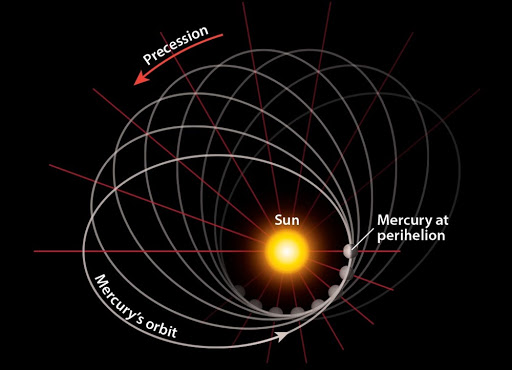


The total perihelion precession rate for Mercury is 5.32+0.43= 5.75 arc seconds per year, where the 5.32 comes from the Newtonian contribution and before General Relativity the 0.43 arc seconds per year was a long standing discrepancy that cannot be solved. It turns out, the ability of general relativity to explain the discrepancy between the observed perihelion precession rate of Mercury, and that calculated from Newtonian dynamics, was one of the first major successes of this theory.

The following text and codes are prepared by Mr.[Tim-Lok Chau](https://quantummc.xyz/members/tim-lok-chau/) and [ZYM](https://quantummc.xyz/members/ziyang-meng/) utilising the following useful references:

1. A primer to numerical simulations: the perihelion motion of Mercury, \\
C Körber, I Hammer, J-L Wynen, J Heuer, C Müller and C Hanhart  \\
[Phys. Educ. 53 055007 (2018)](https://iopscience.iop.org/article/10.1088/1361-6552/aac487)

2. Lecture notes on Newtonian Dynamics by Prof. Richard Fitzpatrick, The University of Texas at Austin \\
Chapter on Gravitational Potential Theory \\
[Perihelion Precession of Mercury](https://farside.ph.utexas.edu/teaching/336k/Newton/node116.html)

The Mecury perhelion procession can be described by the following equation,

$$\ddot{\vec{r}} = - \frac{c^2}{2} \frac{r_s}{r^2} ( 1 + \alpha \frac{r_s}{r} + \beta \frac{r_L^2}{r^2} ) \frac{\vec{r}}{r}$$

where,
- $c$ is the light speed
- $r_s$ is the Schwarzschild radius. It is defined as $\frac{2 G_N M_{sun}}{c^2}$, where $G_N$ is the Newtonian constant of gravition and $M_{sun}$ is the mass of sun
- $r_L$ is the constant that characterize the dynamics of Mercury.

It is worthwhile to mention that $\alpha$ & $\beta$ are constants that characterize the correction to the Mercury's orbit. With $\alpha = \beta = 0$, the differential equation above would become a standard Newtonian law of gravitation (i.e. $a = \frac{GM}{r^2} \frac{\vec{r}}{r}$) between 2 bodies.

### Discussion of the choice of $\Delta t$

Before we get into the updating process, it is worthwhile to discuss the choice of $\Delta t$. A large $\Delta t$ would lead to accumulation of error during update (as shown in last [colab notebook](https://colab.research.google.com/github/timlok123/PHYS4150-Computational-Physics-2024/blob/main/Solving%20ODE/Differential_Equations_1_Methods.ipynb)). In order to choose a suitable $\Delta t$, one can consider the Talyor expansion of position vector $\vec{r}$ at $t+\Delta t$ time steps (i.e. $\vec{r}(t+\Delta t)$),  

$$\vec{r}(t+ \Delta t) = \vec{r}(t) + \dot{\vec{r}}(t) \Delta t + \frac{1}{2} \ddot{\vec{r}}(t) (\Delta  t)^2 + ... = \vec{r}(t) + \vec{v}(t) \Delta  t+ \frac{1}{2} \vec{a}(t) (\Delta  t)^2 + ...$$

If we are using Euler method to update the position, then we'd better make sure  $|\vec{v}(t)| >> |\frac{1}{2} \vec{a}(t) (\Delta  t)|$  (This is also applicable to other methods), such that the higher order terms won't dominate.

### Result by different ODE solving methods

In order to make the Mecury perihelion precession more obvious, the eccentricity of the orbit are tuned to be higher (i.e. setting the initial radius of Mercury to be $6 R_0$ instead of $4 R_0$, while $\alpha$ and $\beta$ are set to large values).

The following are the Mercury's orbit computed with
- Euler method
- Leap frog method
- 4th order Runge Kutta method

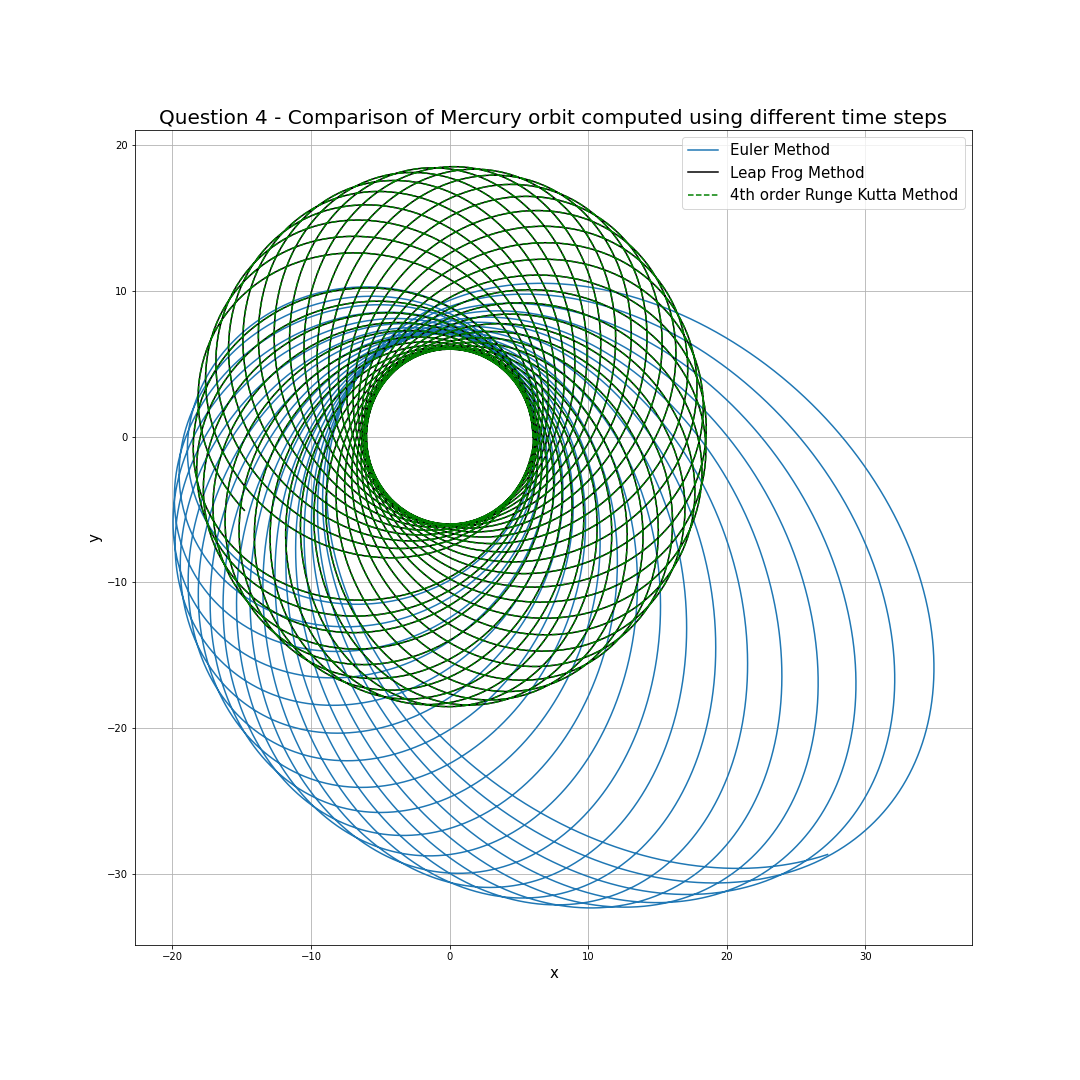

## Perihelion angular position ($\Theta$) and the shift ($\delta \Theta$)

For Mercury orbit, the perihelion position would change after every revolution. The shift, indeed for small $\alpha$ and $\beta$ ($<10^{5}$), it follows the following expression,

$$\delta \Theta (\alpha, \beta) = m_{\alpha} * \alpha + m_{\beta} * \beta$$

The General Relativity predicts $\alpha = 0$ and $\beta =3$. Therefore, in the following of this section, we would keep $\alpha=0$ and $\beta = 3$. Therefore, in the following of the section, we would

1. Fix $\alpha=0$ and vary $\beta$ value to find the $m_{\beta}$ value
2. Put $\alpha=0$ and $\beta = 3$ to the above equation and see the whether the value of $\delta \Theta$ matches with the literature value.

Below is the orbit computed using **4th order Runge Kutta method** and the perihelions are shown below,

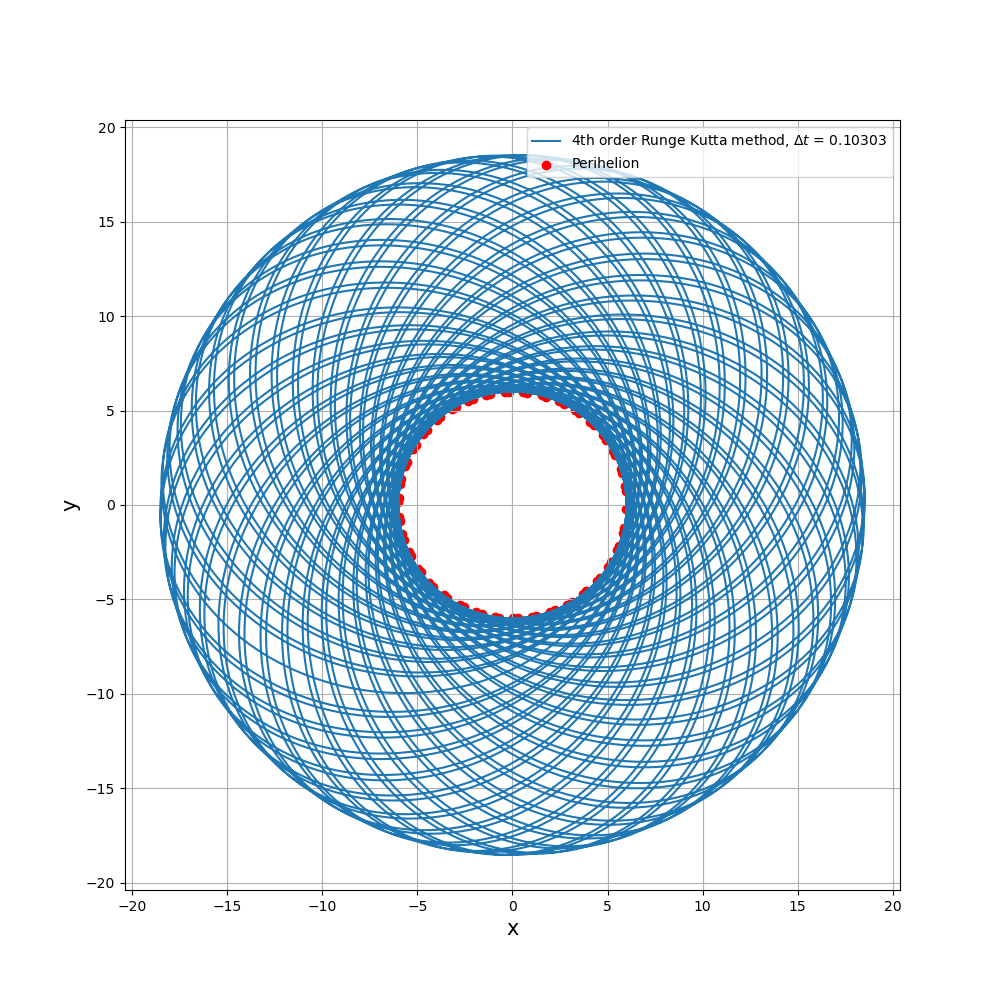

We then vary the value  of $\beta$ and plot the $\delta \Theta$ value versus $\beta$. The result is shown below.

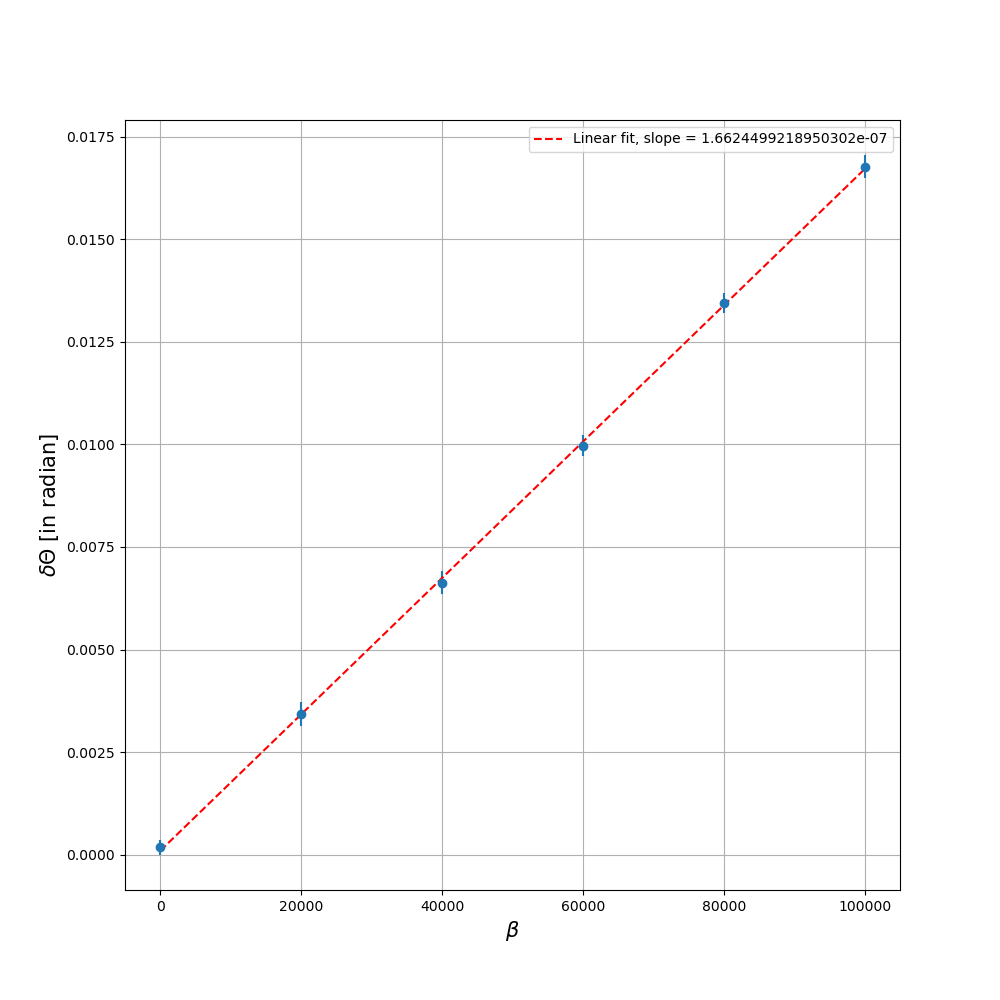

Put the result back to the inital equation,

$$\delta \Theta (\alpha = 0 , \beta = 3 ) = (1.66245 \times 10^{-7}) * (3) = 0.102″$$

where ″ refer to arc second and $1″ = (\frac{1}{3600})°$. Then, consider the ratio of the Earth year to Mercury $T_E/T_M \approx 4.15$, $\delta \Theta \approx 415 \times 0.102″ = 42.33″$, where our result is quite close to the theoretical prediction.